In [428]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# data plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("data/combined_expression.csv")
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.head()

CELL_LINE_NAME  cluster    TSPAN6      TNMD       DPM1     SCYL3  C1orf112  \
0         1240123        1  8.319417  3.111183   9.643558  4.757258  3.919757   
1         1240131        0  7.611268  2.704739  10.276079  3.650299  3.481567   
2         1240132        0  7.678658  2.845781  10.180954  3.573048  3.431235   
3         1240134        0  3.265063  3.063746  10.490285  3.340791  3.676912   
4         1240140        0  7.090138  2.988043  10.264692  4.119555  3.432585   

        FGR       CFH     FUCA2  ...   C6orf10   TMEM225    NOTCH4      PBX2  \
0  3.602185  3.329644  9.076950  ...  3.085394  3.462811  3.339030  4.614897   
1  3.145538  3.565127  7.861068  ...  2.801456  2.985889  3.180068  5.415729   
2  3.090781  4.116643  8.121190  ...  2.934962  2.952937  3.164655  5.707506   
3  3.512821  3.873922  8.790851  ...  3.041839  3.398847  3.106710  5.773963   
4  3.308033  3.318371  6.927761  ...  3.028787  3.225982  3.275820  5.334283   

       AGER      RNF5    AGPAT1    DFNB59     PRRT1     FKBPL  
0  3.395845  3.419193  3.971646  3.729310  3.320022  6.447316  
1  3.299858  3.028414  3.877889  3.911516  3.379405  4.729557  
2  3.434295  2.961345  4.272194  3.085696  3.002557  5.653588  
3  3.412641  3.136110  4.422262  3.522122  3.509437  5.953242  
4  3.864678  3.259242  3.840581  5.809553  3.674587  5.577503  

[5 rows x 16384 columns]

In [3]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [4]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [389]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 5-Fold Validation for 5 Hidden Layers

In [6]:
def hidden5(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [353]:
model5 = KerasClassifier(build_fn=hidden5, epochs=50, batch_size=16, optimizer='adagrad',init='normal')
kf = KFold(n_splits=5)

cm_results5 = []
history_results5 = []
tprs5 = []
base_fpr5 = np.linspace(0, 1, 101)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    # fitting
    history5 = model5.fit(X_train, y_train, validation_data=(X_test,y_test))
    # recording
    cm_results5.append(confusion_matrix(y_test, model5.predict(X_test)))
    history_results5.append(history)
    # auc
    y_score = model5.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    tpr = np.interp(base_fpr5, fpr, tpr)
    tpr[0] = 0.0
    tprs5.append(tpr)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 3s 8ms/sample - loss: 0.6386 - accuracy: 0.7222 - val_loss: 0.3352 - val_accuracy: 0.9174
Epoch 2/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.5369 - accuracy: 0.7731 - val_loss: 0.3084 - val_accuracy: 0.9174
Epoch 3/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4521 - accuracy: 0.8380 - val_loss: 0.3554 - val_accuracy: 0.9174
Epoch 4/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4210 - accuracy: 0.8241 - val_loss: 0.2829 - val_accuracy: 0.9450
Epoch 5/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4411 - accuracy: 0.8287 - val_loss: 0.2672 - val_accuracy: 0.9358
Epoch 6/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.4164 - accuracy: 0.8426 - val_loss: 0.2152 - val_accuracy: 0.9450
Epoch 7/50
432/432 [==============================] - 1s 2ms/sample - loss: 0.3694 - accur

Epoch 7/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3930 - accuracy: 0.8799 - val_loss: 0.5301 - val_accuracy: 0.7685
Epoch 8/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3907 - accuracy: 0.8383 - val_loss: 0.5605 - val_accuracy: 0.8148
Epoch 9/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3709 - accuracy: 0.8453 - val_loss: 0.5844 - val_accuracy: 0.8056
Epoch 10/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3676 - accuracy: 0.8753 - val_loss: 0.5737 - val_accuracy: 0.8148
Epoch 11/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3185 - accuracy: 0.8799 - val_loss: 0.6153 - val_accuracy: 0.7870
Epoch 12/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2787 - accuracy: 0.8868 - val_loss: 0.6039 - val_accuracy: 0.8241
Epoch 13/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3417 - accuracy: 0.8684 - val_loss: 0.6020 - val_accur

433/433 [==============================] - 1s 3ms/sample - loss: 0.3780 - accuracy: 0.8499 - val_loss: 0.5343 - val_accuracy: 0.8148
Epoch 14/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2706 - accuracy: 0.8938 - val_loss: 0.5565 - val_accuracy: 0.8241
Epoch 15/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2850 - accuracy: 0.8868 - val_loss: 0.5535 - val_accuracy: 0.8241
Epoch 16/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2595 - accuracy: 0.9030 - val_loss: 0.5589 - val_accuracy: 0.8333
Epoch 17/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2581 - accuracy: 0.9076 - val_loss: 0.5843 - val_accuracy: 0.8333
Epoch 18/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3397 - accuracy: 0.8776 - val_loss: 0.5865 - val_accuracy: 0.8333
Epoch 19/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2572 - accuracy: 0.9007 - val_loss: 0.5947 - val_accuracy: 0.83

433/433 [==============================] - 1s 3ms/sample - loss: 0.2749 - accuracy: 0.8961 - val_loss: 0.5189 - val_accuracy: 0.8611
Epoch 20/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2948 - accuracy: 0.8891 - val_loss: 0.5189 - val_accuracy: 0.8611
Epoch 21/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3591 - accuracy: 0.8522 - val_loss: 0.5371 - val_accuracy: 0.8519
Epoch 22/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.3068 - accuracy: 0.8938 - val_loss: 0.5411 - val_accuracy: 0.8519
Epoch 23/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2618 - accuracy: 0.8961 - val_loss: 0.5326 - val_accuracy: 0.8519
Epoch 24/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2882 - accuracy: 0.8868 - val_loss: 0.5321 - val_accuracy: 0.8704
Epoch 25/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2510 - accuracy: 0.8984 - val_loss: 0.5267 - val_accuracy: 0.85

433/433 [==============================] - 1s 3ms/sample - loss: 0.2492 - accuracy: 0.9030 - val_loss: 0.4430 - val_accuracy: 0.8148
Epoch 26/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2362 - accuracy: 0.8984 - val_loss: 0.4600 - val_accuracy: 0.8241
Epoch 27/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2438 - accuracy: 0.9122 - val_loss: 0.4378 - val_accuracy: 0.8333
Epoch 28/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2403 - accuracy: 0.9030 - val_loss: 0.4418 - val_accuracy: 0.7963
Epoch 29/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2627 - accuracy: 0.8799 - val_loss: 0.4417 - val_accuracy: 0.7870
Epoch 30/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2780 - accuracy: 0.8845 - val_loss: 0.4415 - val_accuracy: 0.7963
Epoch 31/50
433/433 [==============================] - 1s 3ms/sample - loss: 0.2057 - accuracy: 0.9215 - val_loss: 0.4455 - val_accuracy: 0.78

In [354]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results5:
    for j in cm_results5[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

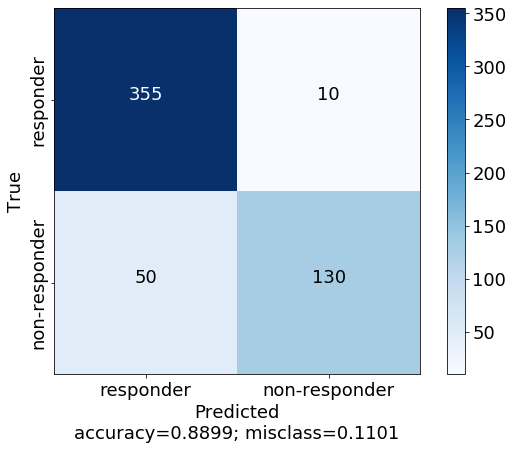

In [355]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='', normalize=False)

# 4 Hidden Layers

In [222]:
def hidden4(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [356]:
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
kf = KFold(n_splits=5)

cm_results4 = []
history_results4 = []
tprs4 = []
base_fpr4 = np.linspace(0, 1, 101)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    # fitting
    history4 = model4.fit(X_train, y_train, validation_data=(X_test,y_test))
    # recording
    cm_results4.append(confusion_matrix(y_test, model4.predict(X_test)))
    history_results4.append(history)
    # auc
    y_score = model4.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    tpr = np.interp(base_fpr4, fpr, tpr)
    tpr[0] = 0.0
    tprs4.append(tpr)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 4s 8ms/sample - loss: 0.7068 - accuracy: 0.7106 - val_loss: 1.2053 - val_accuracy: 0.6697
Epoch 2/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.4825 - accuracy: 0.8264 - val_loss: 0.7311 - val_accuracy: 0.6881
Epoch 3/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.4188 - accuracy: 0.8449 - val_loss: 0.3408 - val_accuracy: 0.8624
Epoch 4/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3036 - accuracy: 0.8773 - val_loss: 0.3566 - val_accuracy: 0.8349
Epoch 5/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3343 - accuracy: 0.8542 - val_loss: 0.2511 - val_accuracy: 0.9174
Epoch 6/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.2630 - accuracy: 0.9028 - val_loss: 0.2092 - val_accuracy: 0.9266
Epoch 7/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3252 - accur

Epoch 7/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2471 - accuracy: 0.9007 - val_loss: 0.5147 - val_accuracy: 0.8426
Epoch 8/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2155 - accuracy: 0.9076 - val_loss: 0.5055 - val_accuracy: 0.8333
Epoch 9/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2009 - accuracy: 0.9307 - val_loss: 0.5164 - val_accuracy: 0.8333
Epoch 10/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2088 - accuracy: 0.9284 - val_loss: 0.5224 - val_accuracy: 0.8241
Epoch 11/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1862 - accuracy: 0.9330 - val_loss: 0.4990 - val_accuracy: 0.8519
Epoch 12/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2000 - accuracy: 0.9215 - val_loss: 0.5452 - val_accuracy: 0.8241
Epoch 13/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1505 - accuracy: 0.9400 - val_loss: 0.5442 - val_accur

433/433 [==============================] - 1s 2ms/sample - loss: 0.1899 - accuracy: 0.9238 - val_loss: 0.6843 - val_accuracy: 0.7870
Epoch 14/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1410 - accuracy: 0.9538 - val_loss: 0.6795 - val_accuracy: 0.7778
Epoch 15/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1450 - accuracy: 0.9446 - val_loss: 0.6265 - val_accuracy: 0.8056
Epoch 16/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1275 - accuracy: 0.9538 - val_loss: 0.6554 - val_accuracy: 0.8056
Epoch 17/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1517 - accuracy: 0.9561 - val_loss: 0.6831 - val_accuracy: 0.7963
Epoch 18/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1405 - accuracy: 0.9515 - val_loss: 0.6217 - val_accuracy: 0.7963
Epoch 19/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.0943 - accuracy: 0.9700 - val_loss: 0.6175 - val_accuracy: 0.79

433/433 [==============================] - 1s 2ms/sample - loss: 0.1435 - accuracy: 0.9515 - val_loss: 0.8081 - val_accuracy: 0.7870
Epoch 20/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1536 - accuracy: 0.9353 - val_loss: 0.7043 - val_accuracy: 0.8241
Epoch 21/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1912 - accuracy: 0.9330 - val_loss: 0.7598 - val_accuracy: 0.8056
Epoch 22/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1167 - accuracy: 0.9538 - val_loss: 0.7714 - val_accuracy: 0.8056
Epoch 23/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1573 - accuracy: 0.9423 - val_loss: 0.7171 - val_accuracy: 0.8333
Epoch 24/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1291 - accuracy: 0.9561 - val_loss: 0.8272 - val_accuracy: 0.7778
Epoch 25/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1421 - accuracy: 0.9423 - val_loss: 0.9253 - val_accuracy: 0.73

433/433 [==============================] - 1s 2ms/sample - loss: 0.1924 - accuracy: 0.9446 - val_loss: 0.4731 - val_accuracy: 0.7963
Epoch 26/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1061 - accuracy: 0.9584 - val_loss: 0.4987 - val_accuracy: 0.7685
Epoch 27/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1041 - accuracy: 0.9584 - val_loss: 0.5091 - val_accuracy: 0.7778
Epoch 28/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1055 - accuracy: 0.9723 - val_loss: 0.5188 - val_accuracy: 0.7500
Epoch 29/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1668 - accuracy: 0.9446 - val_loss: 0.5246 - val_accuracy: 0.7870
Epoch 30/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1114 - accuracy: 0.9630 - val_loss: 0.5339 - val_accuracy: 0.7593
Epoch 31/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1293 - accuracy: 0.9400 - val_loss: 0.5418 - val_accuracy: 0.79

In [357]:
cm4 = [[0, 0]]
k, l = 0, 0
for i in cm_results4:
    for j in cm_results4[0]:
        cm4[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm4 = np.array(cm4[0])

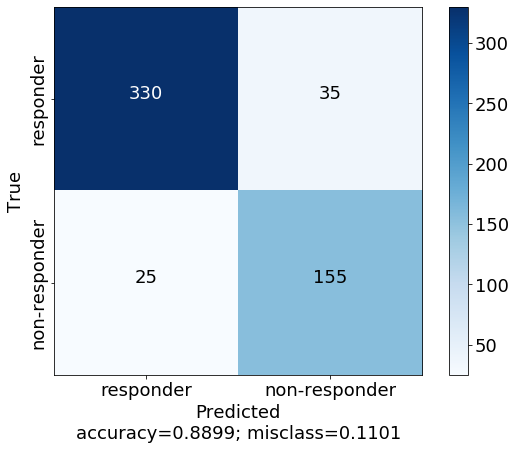

In [358]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm4, ['responder', 'non-responder'], title='', normalize=False)

# 3 Hidden Layers

In [251]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [359]:
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
kf = KFold(n_splits=5)

cm_results3 = []
history_results3 = []
tprs3 = []
base_fpr3 = np.linspace(0, 1, 101)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y[train_index], y[test_index]
    # fitting
    history3 = model3.fit(X_train, y_train, validation_data=(X_test,y_test))
    # recording
    cm_results3.append(confusion_matrix(y_test, model3.predict(X_test)))
    history_results3.append(history)
    # auc
    y_score = model3.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    tpr = np.interp(base_fpr3, fpr, tpr)
    tpr[0] = 0.0
    tprs3.append(tpr)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 3s 7ms/sample - loss: 0.6120 - accuracy: 0.7477 - val_loss: 1.2871 - val_accuracy: 0.3303
Epoch 2/50
432/432 [==============================] - 0s 849us/sample - loss: 0.4276 - accuracy: 0.8310 - val_loss: 2.6826 - val_accuracy: 0.3303
Epoch 3/50
432/432 [==============================] - 0s 851us/sample - loss: 0.3908 - accuracy: 0.8403 - val_loss: 1.7043 - val_accuracy: 0.3303
Epoch 4/50
432/432 [==============================] - 0s 873us/sample - loss: 0.3586 - accuracy: 0.8565 - val_loss: 1.3805 - val_accuracy: 0.3303
Epoch 5/50
432/432 [==============================] - 0s 851us/sample - loss: 0.2990 - accuracy: 0.8889 - val_loss: 1.3071 - val_accuracy: 0.3303
Epoch 6/50
432/432 [==============================] - 0s 848us/sample - loss: 0.3192 - accuracy: 0.8866 - val_loss: 1.3048 - val_accuracy: 0.3303
Epoch 7/50
432/432 [==============================] - 0s 879us/sample - loss: 0.

433/433 [==============================] - 0s 913us/sample - loss: 0.2340 - accuracy: 0.8984 - val_loss: 0.9311 - val_accuracy: 0.4167
Epoch 7/50
433/433 [==============================] - 0s 904us/sample - loss: 0.2009 - accuracy: 0.9145 - val_loss: 0.5480 - val_accuracy: 0.7963
Epoch 8/50
433/433 [==============================] - 0s 916us/sample - loss: 0.2142 - accuracy: 0.9261 - val_loss: 0.6371 - val_accuracy: 0.7130
Epoch 9/50
433/433 [==============================] - 0s 915us/sample - loss: 0.1849 - accuracy: 0.9446 - val_loss: 0.7313 - val_accuracy: 0.6296
Epoch 10/50
433/433 [==============================] - 0s 911us/sample - loss: 0.1727 - accuracy: 0.9284 - val_loss: 1.2426 - val_accuracy: 0.3611
Epoch 11/50
433/433 [==============================] - 0s 909us/sample - loss: 0.1539 - accuracy: 0.9376 - val_loss: 0.7130 - val_accuracy: 0.6852
Epoch 12/50
433/433 [==============================] - 0s 911us/sample - loss: 0.1586 - accuracy: 0.9492 - val_loss: 0.6593 - val_acc

Epoch 12/50
433/433 [==============================] - 0s 981us/sample - loss: 0.1697 - accuracy: 0.9353 - val_loss: 0.7930 - val_accuracy: 0.6204
Epoch 13/50
433/433 [==============================] - 0s 986us/sample - loss: 0.1246 - accuracy: 0.9654 - val_loss: 0.6877 - val_accuracy: 0.6759
Epoch 14/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1351 - accuracy: 0.9515 - val_loss: 0.6373 - val_accuracy: 0.7315
Epoch 15/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1291 - accuracy: 0.9446 - val_loss: 0.6807 - val_accuracy: 0.7037
Epoch 16/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1481 - accuracy: 0.9376 - val_loss: 0.6253 - val_accuracy: 0.7130
Epoch 17/50
433/433 [==============================] - 0s 999us/sample - loss: 0.1387 - accuracy: 0.9446 - val_loss: 0.7078 - val_accuracy: 0.7407
Epoch 18/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1249 - accuracy: 0.9561 - val_loss: 0.6634 - 

433/433 [==============================] - 0s 1ms/sample - loss: 0.1905 - accuracy: 0.9192 - val_loss: 0.5712 - val_accuracy: 0.8333
Epoch 19/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1699 - accuracy: 0.9400 - val_loss: 0.6125 - val_accuracy: 0.8148
Epoch 20/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1245 - accuracy: 0.9607 - val_loss: 0.6360 - val_accuracy: 0.8056
Epoch 21/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1294 - accuracy: 0.9515 - val_loss: 0.7326 - val_accuracy: 0.7593
Epoch 22/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1757 - accuracy: 0.9469 - val_loss: 0.7357 - val_accuracy: 0.7500
Epoch 23/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1038 - accuracy: 0.9677 - val_loss: 0.6106 - val_accuracy: 0.8148
Epoch 24/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1328 - accuracy: 0.9492 - val_loss: 0.6524 - val_accuracy: 0.78

433/433 [==============================] - 0s 1ms/sample - loss: 0.1683 - accuracy: 0.9215 - val_loss: 0.4751 - val_accuracy: 0.8333
Epoch 25/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1076 - accuracy: 0.9677 - val_loss: 0.4601 - val_accuracy: 0.8426
Epoch 26/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1378 - accuracy: 0.9538 - val_loss: 0.4754 - val_accuracy: 0.8519
Epoch 27/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.0867 - accuracy: 0.9769 - val_loss: 0.4638 - val_accuracy: 0.8519
Epoch 28/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1109 - accuracy: 0.9654 - val_loss: 0.4463 - val_accuracy: 0.8519
Epoch 29/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1221 - accuracy: 0.9423 - val_loss: 0.4732 - val_accuracy: 0.8426
Epoch 30/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.0951 - accuracy: 0.9769 - val_loss: 0.5136 - val_accuracy: 0.82

In [360]:
cm3 = [[0, 0]]
k, l = 0, 0
for i in cm_results3:
    for j in cm_results3[0]:
        cm3[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm3 = np.array(cm3[0])
cm3

array([[330,  35],
       [ 35, 145]])

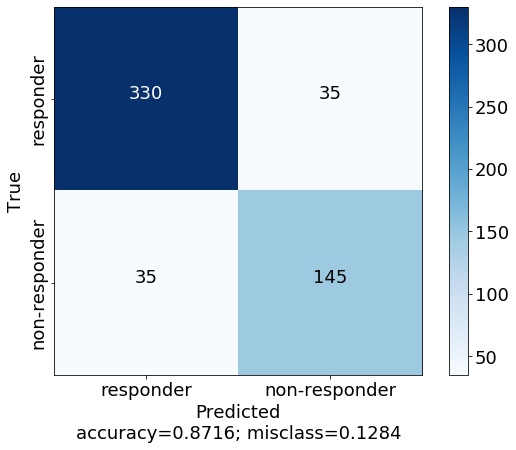

In [361]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm3, ['responder', 'non-responder'], title='', normalize=False)

# Comparison Plots

In [495]:
# for 5 hidden layers
tprs5 = np.array(tprs5)
mean_tprs5 = tprs5.mean(axis=0)
std5 = tprs5.std(axis=0)
tprs_upper5 = np.minimum(mean_tprs5 + std5, 1)
tprs_lower5 = mean_tprs5 - std5
auc5 = auc(base_fpr5, mean_tprs5)

In [496]:
# for 4 hidden layers
tprs4 = np.array(tprs4)
mean_tprs4 = tprs4.mean(axis=0)
std4 = tprs4.std(axis=0)
tprs_upper4 = np.minimum(mean_tprs4 + std4, 1)
tprs_lower4 = mean_tprs4 - std4
auc4 = auc(base_fpr4, mean_tprs4)

In [497]:
# for 3 hidden layers
tprs3 = np.array(tprs3)
mean_tprs3 = tprs3.mean(axis=0)
std3 = tprs3.std(axis=0)
tprs_upper3 = np.minimum(mean_tprs3 + std3, 1)
tprs_lower3 = mean_tprs3 - std3
auc3 = auc(base_fpr3, mean_tprs3)

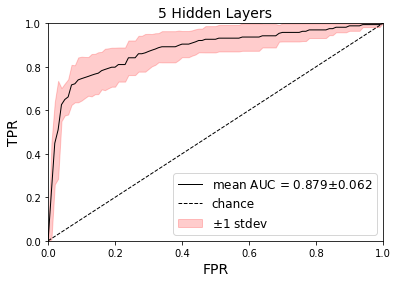

In [555]:
# 5 hidden layers
plt.plot(base_fpr5, mean_tprs5, color='k', linewidth=1)
plt.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('5 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)), 'chance', '$\pm1$ stdev'],
           fontsize=12)

plt.show()

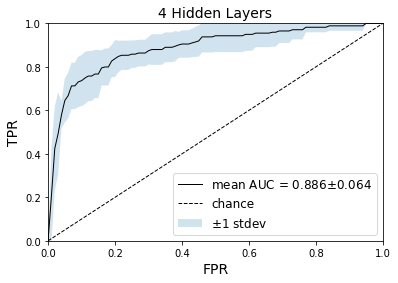

In [554]:
# 4 hidden layers
plt.plot(base_fpr4, mean_tprs4, 'k', linewidth=1)
plt.fill_between(base_fpr4, tprs_lower4, tprs_upper4, alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('4 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc4, 3)) + '$\pm$' + str(round(np.mean(std4), 3)), 'chance', '$\pm1$ stdev'],
           fontsize=12)
plt.show()

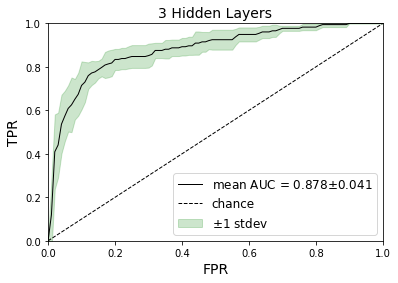

In [557]:
# 3 hidden layers
plt.plot(base_fpr3, mean_tprs3, 'k', linewidth=1)
plt.fill_between(base_fpr3, tprs_lower3, tprs_upper3, alpha=0.2, color='g')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('3 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc3, 3)) + '$\pm$' + str(round(np.mean(std3), 3)),
            'chance',
            '$\pm1$ stdev'],
           fontsize=12)
plt.show()

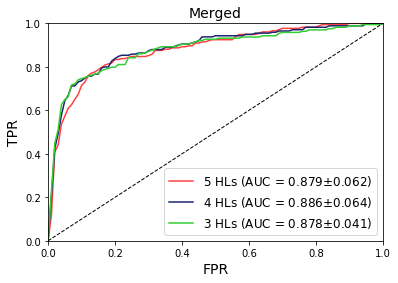

In [622]:
# merged
# 5 hidden layers
plt.plot(base_fpr3, mean_tprs3, '#ff0000', linewidth=1.5, alpha=0.75)
# 4 hidden layers
plt.plot(base_fpr4, mean_tprs4, '#1a236e', linewidth=1.5, alpha=1)
# 3 hidden layers
plt.plot(base_fpr5, mean_tprs5, '#32CD32', linewidth=1.5, alpha=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Merged', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['5 HLs (AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)) + ')',
            '4 HLs (AUC = ' + str(round(auc4, 3)) + '$\pm$' + str(round(np.mean(std4), 3)) + ')',
            '3 HLs (AUC = ' + str(round(auc3, 3)) + '$\pm$' + str(round(np.mean(std3), 3)) + ')'],
           fontsize=12)

plt.show()

In [ ]:
loss, accuracy, val_loss, val_accuracy